# 箱詰めパズル

12種類の両面[ペントミノ](https://ja.wikipedia.org/wiki/%E3%83%9D%E3%83%AA%E3%82%AA%E3%83%9F%E3%83%8E)を特定の形の箱に詰めるパズルです。CP-SATなどのソルバーを使用すれば、簡単に解くことができます。必要な制約条件は `add_exactly_one()` だけです。本章では、箱詰めパズルの解き方を説明します。  

In [2]:
from ortools.sat.python import cp_model
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import tab20
from matplotlib.collections import PatchCollection

## ペントミノのリスト

ペントミノは、位数5のポリオミノです。同じ大きさの正方形を5つ、辺に沿ってつなげた形を指します。回転や鏡映の操作によって同じ形とみなされるものをまとめると、全部で12種類ございます。これらを総称して「ペントミノ」と呼びます。

次のプログラムは、12種類のペントミノを定義し、それらを同じグラフ上に並べて表示します。

In [13]:
pentominos = dict(
F=[" **",    # F
   "** ",
   " * "],
P=["***",    # P
   "** "],
I=["*****"], # I
N=["**  ",   # N
   " ***"],
L=["****",   # L
   "   *"],
T=["***",    # T
   " * ",
   " * "],
U=["* *",    # U
   "***"],
V=["*  ",    # V
   "*  ",
   "***"],
W=["*  ",    # W
   "** ",
  " **"],
X=[" * ",    # X
   "***",
   " * "],
Y=["  * ",   # Y
   "****"],
Z=["** ",    # Z
   " * ",
   " **"]
)

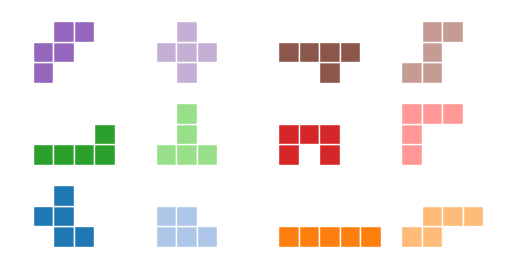

In [14]:
def plot_pentominos(pentominos):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    rectangles = []    
    for i, (name, block) in enumerate(pentominos.items()):
        r, c = np.where(block == '*')
        dx, dy = i % 4 * 6, i // 4 * 4
        for x, y in zip(c + dx, r + dy):
            rectangles.append(plt.Rectangle((x, y), 1, 1, facecolor=tab20.colors[i], edgecolor="white"))
        # ax.text(dx + 1, dy - 1, name)
    collection = PatchCollection(rectangles, match_original=True)
    ax.add_collection(collection)
    ax.autoscale_view()
    ax.axis('off')    

def as_array(b):
    return np.array([list(row) for row in b])

pentominos_arr = {key:as_array(val) for key, val in pentominos.items()}
plot_pentominos(pentominos_arr)

ペントミノは、2次元のNumPy文字配列として表します。`*` はブロックがあることを示し、` `（空白）はブロックがないことを示します。

In [15]:
pentominos_arr['W']

array([['*', ' ', ' '],
       ['*', '*', ' '],
       [' ', '*', '*']], dtype='<U1')

## 箱詰めを解くコード

次の5種類の箱を定義します。箱はNumPyの2次元配列で表し、`1` はブロックを配置できる箇所、`0` は空白のままにしてよい箇所を示します。  

In [18]:
board1 = np.ones((8, 8), dtype=np.uint8)
board1[3:5, 3:5] = 0
board2 = np.ones((3, 20), dtype=np.uint8)
board3 = np.ones((4, 15), dtype=np.uint8)
board4 = np.ones((5, 12), dtype=np.uint8)
board5 = np.ones((6, 10), dtype=np.uint8)

boards = [board1, board2, board3, board4, board5]
print(board1)

[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 0 0 1 1 1]
 [1 1 1 0 0 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]


### ペントミノの配置可能な場所  

次のコードでは、すべてのペントミノが配置可能な場所を算出します。  

ペントミノは `pentomino[:, ::step]` を用いて左右反転し、さらに `np.rot90(fliped_pentomino, r)` を使用して 90° 回転を4回行うことで、合計8種類の状態を生成します。それらを `board` のすべての位置に試し、配置に成功した場合は、そのペントミノの番号と配置したマスの座標を記録します。  

重複を除去するために `set` を用いて配置情報を保存し、最後に `sorted()` を使用してリストに変換します。  

In [36]:
from itertools import product
from collections import defaultdict, namedtuple

Location = namedtuple('Location', 'pentomino cells')

def get_all_locations(pentominos, board):
    ymax, xmax = board.shape
    locations = set()
    for i, pentomino in enumerate(pentominos):
        for step in (1, -1):  # 左右反転
            flipped_pentomino = pentomino[:, ::step]
            for r in range(4):  # 90°回転を4回実行
                rotated_tile = np.rot90(flipped_pentomino, r)
                locy, locx = np.where(rotated_tile == "*")
                for y, x in product(range(ymax), range(xmax)):
                    locy2 = locy + y
                    locx2 = locx + x
                    try:
                        if np.all(board[locy2, locx2] == 1):  # 配置可能か確認
                            loc = tuple(sorted(zip(locy2.tolist(), locx2.tolist())))
                            locations.add(Location(i, loc))
                    except IndexError:
                        pass  # 配置がボード外に出た場合はスキップ

    return sorted(locations)

次のコードでは、0番のペントミノの最初の5つの配置場所を表示します。

In [42]:
locations = get_all_locations(pentominos_arr.values(), boards[0])
for i in range(5):
    print(locations[i])

Location(pentomino=0, cells=((0, 0), (0, 1), (1, 1), (1, 2), (2, 1)))
Location(pentomino=0, cells=((0, 0), (1, 0), (1, 1), (1, 2), (2, 1)))
Location(pentomino=0, cells=((0, 1), (0, 2), (1, 0), (1, 1), (2, 1)))
Location(pentomino=0, cells=((0, 1), (0, 2), (1, 2), (1, 3), (2, 2)))
Location(pentomino=0, cells=((0, 1), (1, 0), (1, 1), (1, 2), (2, 0)))


### 解を求める  

次の `solve_board()` 関数を使用して、箱詰めパズルの解を求めます。まず、`locations` リストから次の2つの辞書を作成します。  

- **`pentomino_locations`**：各ペントミノに対して、配置可能な場所のインデックスを対応付けた辞書。  
- **`cell_locations`**：各マスに対して、そのマスを含む配置のインデックスを対応付けた辞書。  

さらに、`locations` のすべての要素に対応するブール変数 `flags` を作成します。`flags` の値が `True` の場合、その `Location` は有効であることを意味します。  

これらの `pentomino_locations` と `cell_locations` に基づき、次の2つの制約条件を設定します。  

1. **ペントミノの使用回数の制約**（`pentomino_locations`）  
   - 各ペントミノは1回だけ使用できるようにします。  
2. **マスの充填制約**（`cell_locations`）  
   - 各マスは1つのペントミノでのみ埋めることができます。  

この制約を `model.add_exactly_one()`を用いて設定し、最適な解を求めます。

In [46]:
def solve_board(board):
    locations = get_all_locations(pentominos_arr.values(), board)
    
    # pentomino -> location index
    pentomino_locations = defaultdict(list)
    # cell_id -> location index
    cell_locations = defaultdict(list)
    
    for idx, (tile_id, location) in enumerate(locations):
        pentomino_locations[tile_id].append(idx)
        for loc in location:
            cell_locations[loc].append(idx)
    
    model = cp_model.CpModel()
    
    flags = np.array([model.new_bool_var("b{}".format(i)) for i in range(len(locations))])
    
    for d in (pentomino_locations, cell_locations):
        for index in d.values():
            selected_flags = flags[index].tolist()
            model.add_exactly_one(selected_flags)
    
    solver = cp_model.CpSolver()
    solver.solve(model)
    return [locations[i][1] for i, flag in enumerate(flags) if solver.value(flag)]

def plot_solution(solution):
    h, w = np.array(solution).reshape(-1, 2).max(axis=0) + 1
    fig, ax = plt.subplots(figsize=(w * 0.25, h * 0.25))
    ax.set_aspect('equal')

    rectangles = []
    
    for i, block in enumerate(solution):
        for y, x in block:
            rect = plt.Rectangle((x, y), 1, 1, facecolor=tab20.colors[i],edgecolor='white')
            rectangles.append(rect)
            
    collection = PatchCollection(rectangles, match_original=True)
    ax.add_collection(collection)
    ax.autoscale_view()
    ax.invert_yaxis()
    ax.axis('off')
    return fig    

次に、すべての箱について`solve_board()`を実行し、それぞれの解を求め、グラフにします。

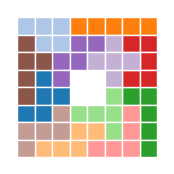

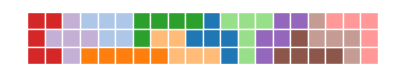

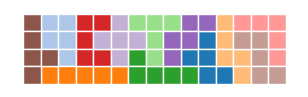

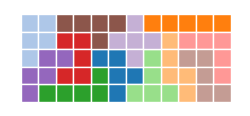

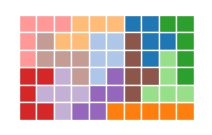

In [47]:
for board in boards:
    solution = solve_board(board)
    plot_solution(solution)